In [223]:
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# I chose data from “https://catalog.data.gov/dataset/current-season-spring-trout-stocking” about the distribution of three Trout species in different areas.
# The data contains nine variables, four of them are location records and two are time records.
# In the following sections I will focus on the remaining three variables, which are the species name of the trout, their number, and the individual size. 
url= 'https://data.ny.gov/api/views/d9y2-n436/rows.csv?accessType=DOWNLOAD'
r = requests.get(url, allow_redirects=True)
open('Current_Season_Spring_Trout_Stocking.csv', 'wb').write(r.content)

131410

In [224]:
df = pd.read_csv(r'Current_Season_Spring_Trout_Stocking.csv',names=['Year','Region','Country','Town','Waterbody','Date','Number','Species','Size']) # rename some columns 
df

,Year,Region,Country,Town,Waterbody,Date,Number,Species,Size
0,Year,DEC Region,County,Town,Waterbody,Date,Number,Species Name,Size (inches )
1,2021,4,Albany,Westerlo,Basic Creek,April - first week,28,Brown Trout,12 -15 inches
2,2021,4,Albany,Westerlo,Basic Creek,April - first week,255,Rainbow Trout,9 - 10 inches
3,2021,4,Albany,Rensselaerville,Catskill Creek,April - first week,20,Brown Trout,12 -15 inches
4,2021,4,Albany,Rensselaerville,Catskill Creek,April - first week,182,Brown Trout,9 - 10 inches
...,...,...,...,...,...,...,...,...,...
1500,2021,9,Wyoming,Perry,Perry Park Pond,Mid April,87,Rainbow Trout,8 inches
1501,2021,9,Wyoming,Orangeville,Tonawanda Creek,March - fourth week,133,Brown Trout,12 -15 inches
1502,2021,9,Wyoming,Orangeville,Tonawanda Creek,March - fourth week,1200,Rainbow Trout,9 - 10 inches
1503,2021,8,Yates,"Milo, Torrey",Keuka Lake Outlet,April - second week,150,Brown Trout,12 -15 inches


In [225]:
df1=df[['Number','Species','Size']].drop(index=0).dropna() # clean missing values 
df1 # this dataset contains only the three main varaibles, they can reflect the specific trout number and size in a location and date.

,Number,Species,Size
1,28,Brown Trout,12 -15 inches
2,255,Rainbow Trout,9 - 10 inches
3,20,Brown Trout,12 -15 inches
4,182,Brown Trout,9 - 10 inches
5,20,Brown Trout,12 -15 inches
...,...,...,...
1500,87,Rainbow Trout,8 inches
1501,133,Brown Trout,12 -15 inches
1502,1200,Rainbow Trout,9 - 10 inches
1503,150,Brown Trout,12 -15 inches


In [226]:
df1.describe() # "Brown Trout" is the most widely distributed specie, 1101 of 1504. 

,Number,Species,Size
count,1504,1504,1504
unique,638,3,4
top,100,Brown Trout,9 - 10 inches
freq,21,1101,584


In [227]:
# From the dataset, the question is: What is the proportion of the total number of these three trout species?
df1.Species.unique() # subset the dataset according to the species names.

array(['Brown Trout', 'Rainbow Trout', 'Brook Trout'], dtype=object)

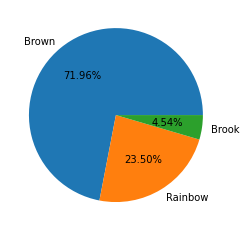

In [228]:
# subsets of species, and their total number.
Brown=df1.loc[df1['Species']=='Brown Trout']
Brook=df1.loc[df1['Species']=='Brook Trout']
Rainbow=df1.loc[df1['Species']=='Rainbow Trout']
num1=Brown['Number'].astype('float').sum()
num2=Rainbow['Number'].astype('float').sum()
num3=Brook['Number'].astype('float').sum()
plt.pie([num1,num2,num3],labels=['Brown','Rainbow','Brook'],autopct='%1.2f%%')
plt.show()
# from the output, the total number of Brown Trout occupies 71.96% of the three species, Rainbow Trout is 23.50%, and Brook Trout total number is only 4.54%.

In [229]:
#Trends: 1. What is the proportion difference between the observations amount and their total number?
print(len(Brown)/len(df1),len(Rainbow)/len(df1),len(Brook)/len(df1))
# As the output shows, the differences are within 0.03.

0.7320478723404256 0.20345744680851063 0.06449468085106383


In [230]:
#Trends: 2. The average number of trout in each observation is:
print(num1/len(Brown),num2/len(Rainbow),num3/len(Brook))
# In each observation, the average number of Brown trout is lower than Rainbow trout, although the observations and total amount of Brown trout is the most;
# the survival of Brook trout is not good, both the number of observations and the number of single observations are significantly lower than the other two species.

1252.8339963669391 1471.943954248366 896.8288659793814


In [231]:
# Predictive analytics question: 
# Can we predict the species of trout by their distribution number and individual size?
# Hypothesis: the total number of Brown trout is larger than other two species, so their number in each observation might also precedes others;
# their size might be smaller than trout that is not so dense in a location, because single trout can get more energy in a less competitive environment. 
df1.Size.unique()

array(['12 -15 inches', '9 - 10 inches', '8 inches', '12 -14 inches'],
      dtype=object)

In [232]:
# From the output above, there are four size range in object type, so we will need to convert them into integers. 
# Here 12-15 and 12-14 ranges can be ambiguous, I will assgin 15 and 14 to distinguish them. Also 9-10 range will be 10.
# Also, we need to make sure the "species" and "number" variables are integers.
df1['Number']=df1.Number.astype('float')
first=df1.loc[df1['Size']=='12 -15 inches'].copy()
first['Size']=15
second=df1.loc[df1['Size']=='12 -14 inches'].copy()
second['Size']=14
third=df1.loc[df1['Size']=='9 - 10 inches'].copy()
third['Size']=10
fourth=df1.loc[df1['Size']=='8 inches'].copy()
fourth['Size']=8
# get a new dataset with size in integer format. 
df2=pd.concat([first,second,third,fourth])
# Assign 1,2,3 to the three species as the number from low to high. Brown trout number is the largest so use 3 to represent. 
Brown=df1.loc[df1['Species']=='Brown Trout'].copy()
Brown['Species']=3
Rainbow=df1.loc[df1['Species']=='Rainbow Trout'].copy()
Rainbow['Species']=2
Brook=df1.loc[df1['Species']=='Brook Trout'].copy()
Brook['Species']=1
# get a new dataset with species in integer format.
df3=pd.concat([Brown,Rainbow,Brook])
# df2 is the final version with all integers.
df2['Species']=df3['Species'].values
df2

,Number,Species,Size
1,28.0,3,15
3,20.0,3,15
5,20.0,3,15
7,20.0,3,15
9,20.0,3,15
...,...,...,...
1470,3906.0,1,8
1471,3654.0,1,8
1494,261.0,1,8
1495,261.0,1,8


In [233]:
df2.corr()
# the larger the size is, the trout is more likely to be Brown trout. 
# the number of trout reflects that the Brook trout distuibution is more dense than Brown trout.

,Number,Species,Size
Number,1.000000,-0.187765,-0.266550
Species,-0.187765,1.000000,0.627194
Size,-0.266550,0.627194,1.000000


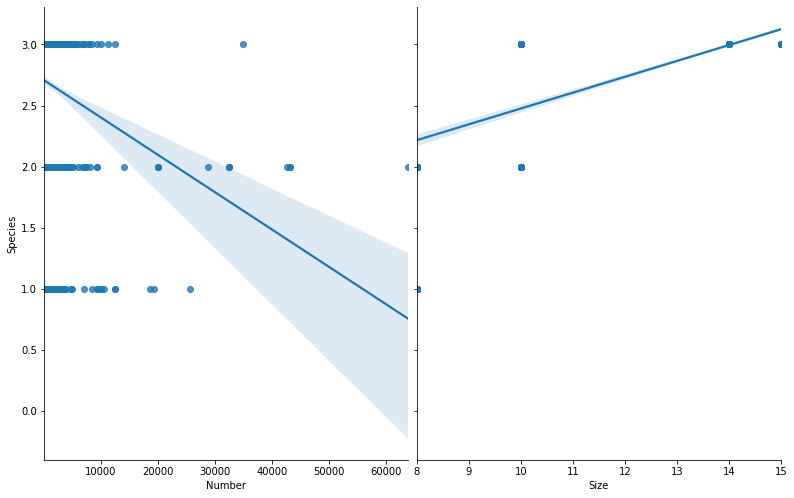

In [234]:
# The influence of number and size on species
sns.pairplot(df2, x_vars=['Number','Size'], y_vars='Species', height=7, aspect=0.8,kind = 'reg')
plt.show()

In [235]:
# build train model and test model, find the intercept and coefficients.
X_train,X_test,Y_train,Y_test = train_test_split(df2[['Number','Size']],df2.Species,test_size=.20)

model = LinearRegression()

model.fit(X_train,Y_train)

a = model.intercept_  

b = model.coef_ 

print(a,b)
# as the output shows, y= 1.1687 + (-2.77e-06)*Number + (1.30e-01)*Size. The number of trout in each observation increases 1, 
# the "Species" decreases -2.77e-06; "Species" will increase 1.30e-0.1 when the individual size increases 1.

1.2100984669928136 [-5.51591635e-06  1.27587752e-01]


0.38218428858570486


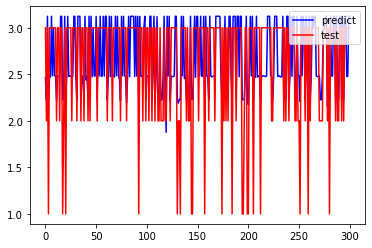

In [236]:
score = model.score(X_test, Y_test)
print(score)   # the larger the value is, the model is more accurate.
Y_pred = model.predict(X_test)
# comparison between predict values and source values.
plt.figure()
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right")
plt.show()

In [237]:
#Conclusion:From the output, in each observation, the influence of trout number is too small to be considered. As for individual size,
# the most widely distributed trout also has largest average size. The hypothesis was not supported by the outputs. One possible reason 
# is that if a trout has a high number, they obtain most of the energy in this area, so their size can also be large. 
# The Positive correlation of size and observations is a suprising trend, because I thought the individual size might not be very large
# if their groups share one environmet, but actually the high number of observations can prove that the environment enables the trout to live.

In [238]:
os.system('jupyter nbconvert --to html CapstoneProject_XinNing.ipynb')

0